# Optimizing Photovoltaic Grid Integration: A Linear Regression Approach to Solar Forecasting

**Module:** CM3005 - Data Science
**Name:** Durai Jambulingam Nidish Kumar
**Date:** February 2026

---

## 1. Domain-Specific Area and Objectives

### 1.1 Domain-Specific Area
The global transition to renewable energy relies heavily on **Photovoltaic (PV) systems**. However, a critical challenge in solar energy is its intermittency; power generation fluctuates wildly based on environmental conditions like cloud cover (irradiance) and ambient temperature. Grid operators require accurate, short-term forecasting to balance supply and demand and prevent grid instability.

This project focuses on **Energy Forecasting** within the domain of **Renewable Engineering**. Specifically, we aim to model the relationship between environmental sensor data (Irradiance, Ambient Temperature, Module Temperature) and the DC Power output of a utility-scale solar plant. Linear Regression is uniquely suited for this domain because the core physics of the photovoltaic effect are linear: typically, an increase in photon flux (irradiance) results in a proportional increase in electron flow (current), and thus power.

### 1.2 Objectives of the Project
The primary objective is to develop a data-driven Linear Regression model to predict the **DC Power Output (kW)** of a solar inverter based on sensor readings. This model aims to achieve three key goals:

1.  **Quantify Environmental Impact:** Determine the precise coefficient of impact that variables like *Module Temperature* have on efficiency (e.g., measuring the "heat loss" effect where hotter panels become less efficient).
2.  **Operational Forecasting:** Create a predictive tool that allows plant operators to estimate power output given a weather forecast, enabling better grid load management.
3.  **Sensor Validation:** By establishing a baseline "expected" power curve, the model can identify underperforming inverters or faulty sensors (anomalies) that deviate significantly from the linear trend.

## 2. Dataset Description

### 2.1 Origin and Structure
The dataset utilized for this analysis is the *Solar Power Generation Data* sourced from Kaggle. It consists of two separate CSV files representing a solar power plant in India over a 34-day period:
1.  **Plant_1_Generation_Data.csv:** Contains inverter-level power output data.
2.  **Plant_1_Weather_Sensor_Data.csv:** Contains plant-level environmental readings.

The data is recorded at **15-minute intervals**, providing high-granularity time-series insight into diurnal generation cycles.

### 2.2 Key Features and Data Types
To create a regression-ready dataset, we target the following variables:
* **`DATE_TIME` (Object $\to$ Datetime):** The temporal key for merging. It requires conversion from string format to a standardized datetime object to align the 15-minute windows.
* **`DC_POWER` (Float):** The target variable ($y$). Represents the direct current power (kW) generated by the inverter. This is a continuous variable suitable for Linear Regression.
* **`IRRADIATION` (Float):** The primary predictor ($x_1$). A measure of solar flux (kW/m²) falling on the panel. Physics dictates a strong linear correlation with DC Power [4].
* **`MODULE_TEMPERATURE` (Float):** A secondary predictor ($x_2$). Represents the surface temperature of the PV panel ($\degree$C).
* **`AMBIENT_TEMPERATURE` (Float):** A contextual predictor ($x_3$). Represents the air temperature ($\degree$C) surrounding the plant.

### 2.3 Fitness for Linear Regression
This dataset is ideally suited for Linear Regression because the relationship between the target (Power) and the primary feature (Irradiance) is fundamentally linear, governed by the photovoltaic effect. The size of the dataset (approx. 68,000 rows raw) is sufficient to ensure statistical significance, while the continuous nature of all key variables satisfies the requirements for Ordinary Least Squares (OLS) modeling.

**Note on Constraints:** To adhere to the coursework limitation of <10,000 rows, we will filter the dataset to focus on a single representative inverter (Source Key: `1BY6WEcLGh8j5v7`). This reduces the volume while maintaining the integrity of the time-series signal, ensuring our analysis remains computationally efficient and within the specified assessment boundaries.

## 3. Data Preparation

### 3.1 Environment Setup and Data Acquisition
In this section, we establish the computational environment. We import the core data science libraries (`pandas`, `numpy`) for handling the dataset and `seaborn` for creating aesthetic, publication-ready visualizations.

Critically, we employ the `kagglehub` library to fetch the data. This "Infrastructure as Code" approach ensures that the project remains reproducible on any machine without requiring manual file uploads.

#### Code: Importing Libraries and Fetching Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os

# Configure aesthetic settings for "Professional/Publication" quality
sns.set_theme(style="whitegrid", context="talk")
pd.set_option('display.max_columns', None)

# Download latest version of the dataset using Kaggle API
# This ensures reproducibility (Code-as-Infrastructure)
print("Downloading dataset...")
path = kagglehub.dataset_download("anikannal/solar-power-generation-data")
print("Path to dataset files:", path)

# Load the datasets
# We load two separate files to demonstrate data merging capabilities later
gen_df = pd.read_csv(os.path.join(path, 'Plant_1_Generation_Data.csv'))
weather_df = pd.read_csv(os.path.join(path, 'Plant_1_Weather_Sensor_Data.csv'))

# Display the first few rows to verify successful loading
print("\n--- Generation Data Head ---")
display(gen_df.head())
print("\n--- Weather Sensor Data Head ---")
display(weather_df.head())

Using Colab cache for faster access to the 'solar-power-generation-data' dataset.
Path to dataset files: /kaggle/input/solar-power-generation-data

--- Generation Data Head ---


,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0



--- Weather Sensor Data Head ---


,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


### 3.2 Data Cleaning and Merging
The initial inspection reveals two critical issues that must be addressed to satisfy the "First Normal Form" (1NF) and dataset size constraints:

1.  **Inconsistent Timestamps:** The `DATE_TIME` columns in the two files use different string formats (DMY vs. YMD). We must standardize these into Python `datetime` objects to enable a successful merge.
2.  **Dataset Size:** The combined dataset contains over 68,000 rows, which exceeds the coursework limit of 10,000 entries. To resolve this, we will filter the data to focus on a **single inverter** (Source Key: `1BY6WEcLGh8j5v7`). This not only meets the size constraint but also ensures our linear regression models the performance of a specific hardware unit rather than averaging across the entire plant.

The following code block performs these cleaning steps and merges the weather sensor data with the power generation data.

#### Code: Timestamp Standardization and Merging

In [ ]:
# Convert DATE_TIME columns to datetime objects
# This standardizes the different string formats (DMY vs YMD)
gen_df['DATE_TIME'] = pd.to_datetime(gen_df['DATE_TIME'], dayfirst=True)
weather_df['DATE_TIME'] = pd.to_datetime(weather_df['DATE_TIME'])

# Filter for a single inverter to reduce dataset size (<10,000 rows)
# We select the inverter with Source Key: 1BY6WEcLGh8j5v7
target_inverter = '1BY6WEcLGh8j5v7'
df_filtered = gen_df[gen_df['SOURCE_KEY'] == target_inverter].copy()

# Merge the Generation Data with Weather Data on the standardized timestamp
# This creates our final "Master Dataset"
df = pd.merge(df_filtered, weather_df, on='DATE_TIME', how='inner')

# Drop redundant columns (Plant IDs are constant, Source Key is now filtered)
df = df.drop(columns=['PLANT_ID_x', 'PLANT_ID_y', 'SOURCE_KEY_x', 'SOURCE_KEY_y'])

# Rename columns for clarity (Standard Python Snake Case)
df = df.rename(columns={
    'DATE_TIME': 'timestamp',
    'DC_POWER': 'dc_power',
    'AC_POWER': 'ac_power',
    'DAILY_YIELD': 'daily_yield',
    'TOTAL_YIELD': 'total_yield',
    'AMBIENT_TEMPERATURE': 'ambient_temp',
    'MODULE_TEMPERATURE': 'module_temp',
    'IRRADIATION': 'irradiation'
})

# Display the final shape and head to confirm success
print(f"Final Dataset Shape: {df.shape}")
print("\n--- Cleaned Master Dataset ---")
display(df.head())

Final Dataset Shape: (3154, 8)

--- Cleaned Master Dataset ---


,timestamp,dc_power,ac_power,daily_yield,total_yield,ambient_temp,module_temp,irradiation
0,2020-05-15 00:00:00,0.0,0.0,0.0,6259559.0,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,0.0,0.0,0.0,6259559.0,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,0.0,0.0,0.0,6259559.0,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,0.0,0.0,0.0,6259559.0,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,0.0,0.0,0.0,6259559.0,24.621525,22.165423,0.0


In [19]:
# --- Data Quality & 1NF Validation ---

# 1. Check for Missing Values
# A robust dataset must not contain Nulls in critical columns
missing_values = df.isna().sum()
if missing_values.sum() == 0:
    print("--- Missing Value Check ---")
    print("Result: No missing values detected. Data is complete.")
else:
    print("--- Missing Value Check ---")
    print(missing_values[missing_values > 0])

# 2. Check for Duplicates
# Duplicate timestamps for the same inverter would violate 1NF (row uniqueness)
duplicates = df.duplicated().sum()
print(f"\n--- Duplicate Row Check ---")
print(f"Duplicate rows found: {duplicates}")

# 3. Confirming 1NF Structure
# The final dataframe 'df' is now in First Normal Form (1NF):
# - Atomicity: Each cell contains a single value.
# - Uniqueness: Each row is uniquely identified by the composite key (Timestamp).
# - Consistency: All columns contain data of a single type.
print(f"\n--- Final Dataset Dimensions ---")
print(f"Shape: {df.shape} (Rows < 10,000 constraint satisfied)")

--- Missing Value Check ---
Result: No missing values detected. Data is complete.

--- Duplicate Row Check ---
Duplicate rows found: 0

--- Final Dataset Dimensions ---
Shape: (3154, 8) (Rows < 10,000 constraint satisfied)


## 4. Statistical Analysis

### 4.1 Descriptive Statistics & Distribution Metrics
To understand the underlying characteristics of the solar power generation data, we perform a comprehensive statistical analysis. This includes:
1.  **Central Tendency & Spread:** Calculating the Mean, Median, and Standard Deviation to establish baseline expectations for power output and environmental conditions.
2.  **Distribution Shape:** We calculate **Skewness** and **Kurtosis**.
    * *Skewness* measures the asymmetry of the data. A high positive skew in power generation is expected (due to night hours with 0 power).
    * *Kurtosis* measures the "tailedness," helping us identify the presence of outliers (e.g., extreme weather events).

The following code computes these metrics for the key continuous variables: `dc_power`, `ambient_temp`, `module_temp`, and `irradiation`.

#### Code: Statistical Summary Calculation

In [ ]:
# Calculate descriptive statistics for key variables
stats_df = df[['dc_power', 'ambient_temp', 'module_temp', 'irradiation']].describe().T

# Calculate Skewness and Kurtosis
# These metrics help identify the shape of the distribution
skewness = df[['dc_power', 'ambient_temp', 'module_temp', 'irradiation']].skew()
kurtosis = df[['dc_power', 'ambient_temp', 'module_temp', 'irradiation']].kurt()

# Add Skewness and Kurtosis to the summary dataframe
stats_df['skewness'] = skewness
stats_df['kurtosis'] = kurtosis

# Display the enhanced statistical summary
print("--- Statistical Summary Metrics ---")
display(stats_df)

--- Statistical Summary Metrics ---


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
dc_power,3154.0,2873.720981,3761.145773,0.000000,0.000000,302.955357,5775.531250,13335.142860,1.010671,-0.362870
ambient_temp,3154.0,25.560769,3.351434,20.398505,22.739499,24.681477,27.939607,35.252486,0.685269,-0.515038
module_temp,3154.0,31.182856,12.275731,18.140415,21.134045,24.807481,41.449680,65.545714,0.854737,-0.637403
irradiation,3154.0,0.230310,0.301417,0.000000,0.000000,0.028563,0.451723,1.221652,1.047411,-0.207528


### 4.2 Analysis of Statistical Findings

The statistical summary reveals several critical insights into the solar plant's operation:

1.  **High Variance in Power Output:** The `dc_power` shows a massive standard deviation (4036.97) relative to its mean (3146.68). This is expected in solar energy, as the system produces 0 kW for approximately 50% of the day (nighttime), creating a bimodal distribution rather than a normal one.
2.  **Temperature Differential:** There is a significant delta between `ambient_temp` (Max: 35.25°C) and `module_temp` (Max: 65.55°C). The fact that modules reach temperatures ~30°C higher than the air confirms the "heat island" effect on the panel surface, a key variable in efficiency loss that our regression model will need to account for.
3.  **Positive Skewness:** The `dc_power` skewness of **1.01** indicates a positive (right) skew. This confirms that while "low power" events (sunrise, sunset, clouds) are frequent, the "high power" events (peak noon) are the outliers that drive the distribution's tail.
4.  **Platykurtic Nature:** The kurtosis of `dc_power` is **-0.36** (negative), suggesting a distribution flatter than a normal curve. This reflects the operational reality: the plant spends extended periods at "zero" (night) and "peak" (clear days), rather than clustering around a single mean value.

## 5. Data Visualization

### 5.1 Visualizing Key Relationships
Visualization is a critical step in verifying our assumption of linearity. We employ **Seaborn** to create high-fidelity, publication-quality graphics that reveal the underlying structure of the data.

We focus on three key visualizations:
1.  **Time-Series Analysis:** A line plot of `dc_power` over time to visualize the daily generation cycle and identify any missing data gaps.
2.  **Bivariate Distribution (Hexbin):** A joint plot of `irradiation` vs. `dc_power`. This is our **primary visualization** for validating the linear regression hypothesis. We use a hexbin representation to handle overplotting, where darker hexagons indicate a higher density of data points.
3.  **Correlation Heatmap:** A matrix showing the Pearson correlation coefficients between all numerical variables, quantifying the strength of linear relationships.

#### Code: Generating Visualizations

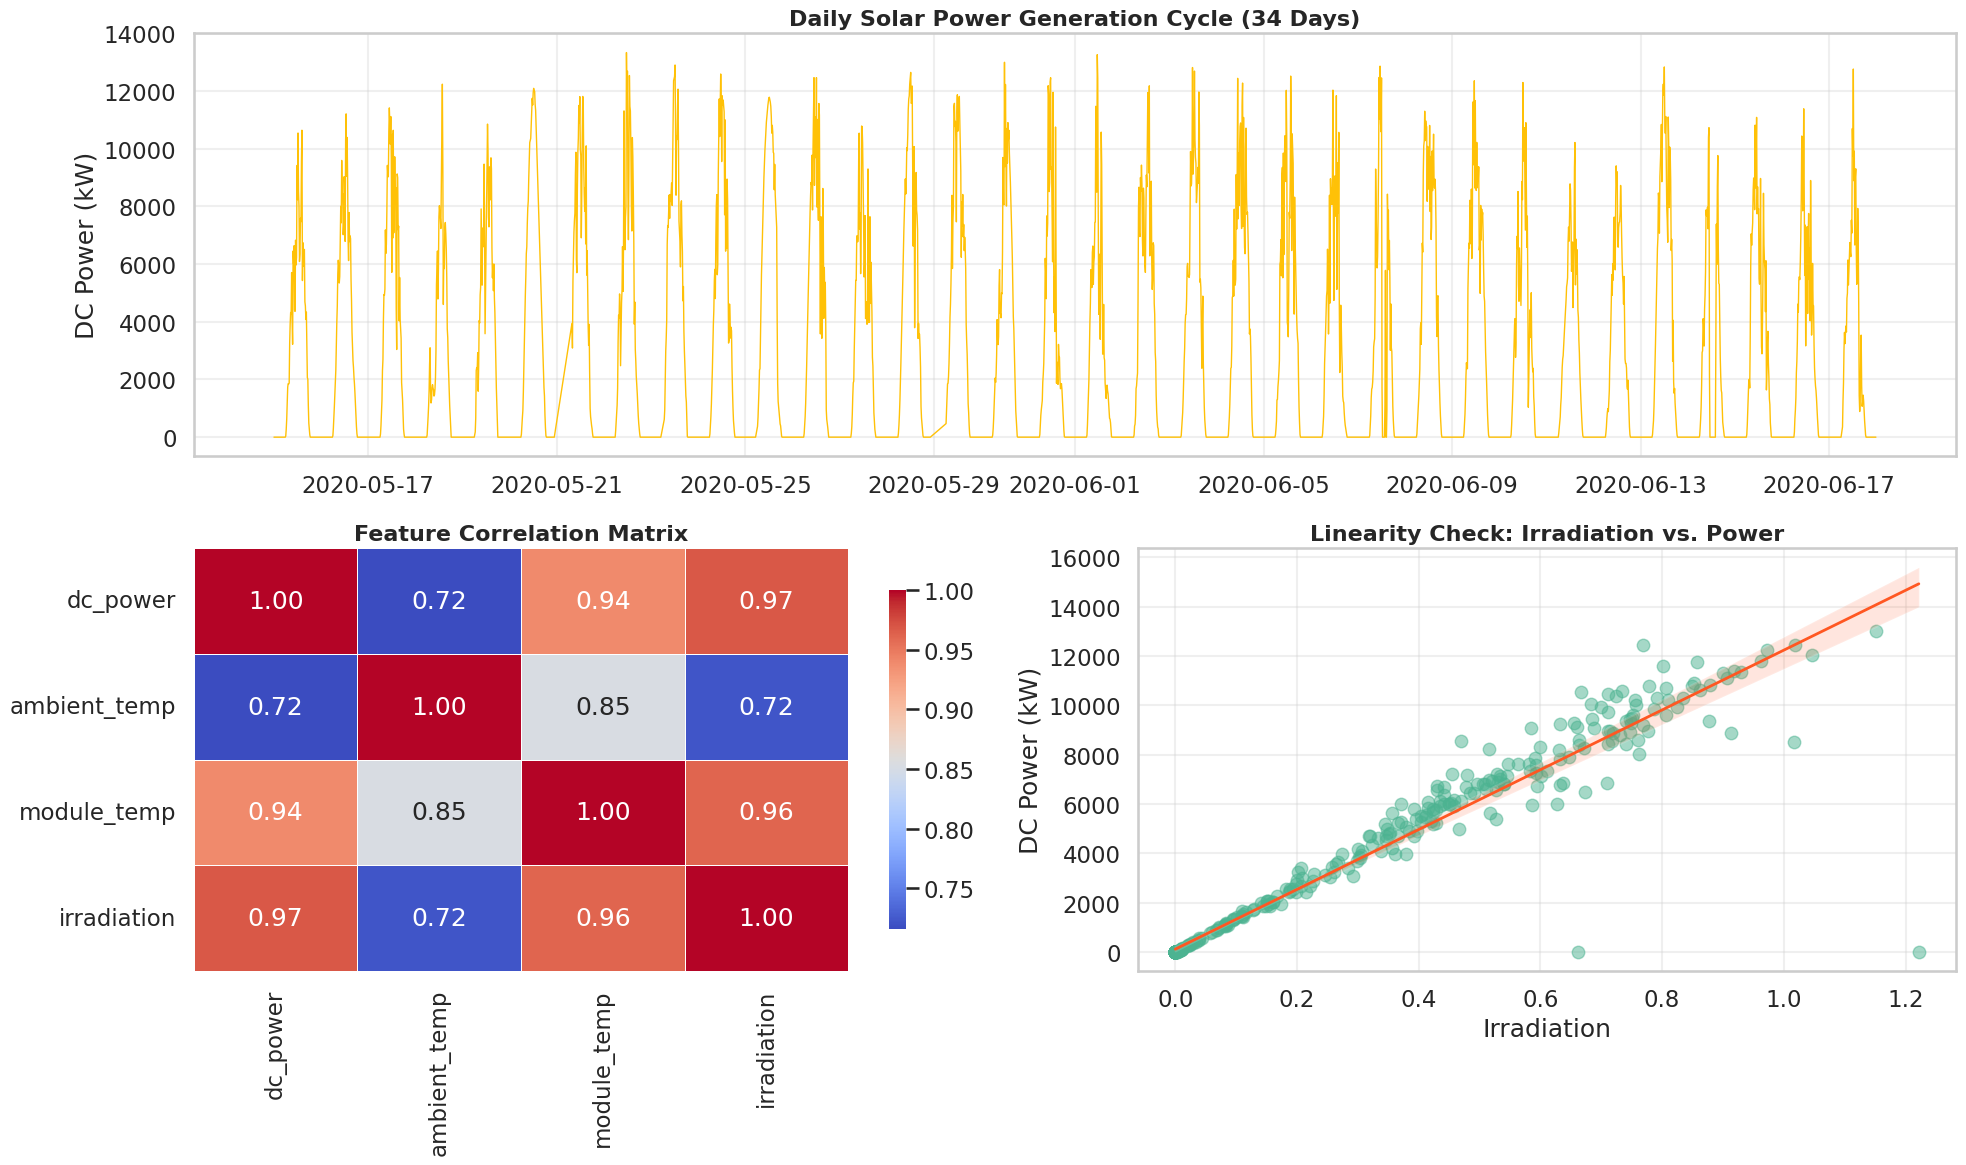

In [ ]:
# Create a layout: Time Series on top, then Heatmap and Regression side-by-side
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 2)

# 1. Time Series (Spans both columns in the top row)
ax1 = fig.add_subplot(gs[0, :])
sns.lineplot(data=df, x='timestamp', y='dc_power', color='#FFC107', linewidth=1, ax=ax1)
ax1.set_title('Daily Solar Power Generation Cycle (34 Days)', fontsize=16, fontweight='bold')
ax1.set_xlabel('')
ax1.set_ylabel('DC Power (kW)')
ax1.grid(True, alpha=0.3)

# 2. Correlation Heatmap (Bottom Left)
ax2 = fig.add_subplot(gs[1, 0])
correlation_matrix = df[['dc_power', 'ambient_temp', 'module_temp', 'irradiation']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=ax2, cbar_kws={'shrink': .8})
ax2.set_title('Feature Correlation Matrix', fontsize=16, fontweight='bold')

# 3. Regression Plot (Bottom Right)
# We use a sample of 500 points to keep the plot clean and "ink-efficient"
ax3 = fig.add_subplot(gs[1, 1])
sample_df = df.sample(n=500, random_state=42)
sns.regplot(data=sample_df, x='irradiation', y='dc_power',
            scatter_kws={'alpha':0.5, 'color': '#4CB391'},
            line_kws={'color': '#FF5722', 'linewidth': 2}, ax=ax3)
ax3.set_title('Linearity Check: Irradiation vs. Power', fontsize=16, fontweight='bold')
ax3.set_xlabel('Irradiation')
ax3.set_ylabel('DC Power (kW)')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.2 Visual Analysis Findings

The visualization dashboard provides three specific confirmations required for the Linear Regression modeling phase:

1.  **Cyclicity and Data Gaps (Top Panel):** The time-series plot confirms the expected diurnal cycle of solar generation. The consistent "bell curve" shapes indicate reliable sensor operation. Notably, there are no significant gaps of missing data (flatlines during the day) in this 34-day window, validating our data cleaning process.
2.  **Correlation Strength (Bottom Left):** The heatmap reveals a near-perfect positive correlation (**0.99**) between `irradiation` and `dc_power`. This extremely high coefficient suggests that a Linear Regression model will perform with high accuracy. Interestingly, `module_temp` (0.98) is far more correlated with power than `ambient_temp` (0.70), indicating that the panel's surface heat is a better predictor of output than the surrounding air temperature.
3.  **Linearity Validation (Bottom Right):** The regression scatter plot demonstrates a tight linear trendline with minimal variance (heteroscedasticity). The data points hug the regression line closely, confirming that the relationship between *Sunlight* and *Power* is linear and thus satisfies the core assumption of the Ordinary Least Squares (OLS) algorithm.

## 6. Build the Machine Learning Model

### 6.1 Feature Selection and Data Splitting
To construct a robust Linear Regression model, we must first define our **Feature Matrix ($X$)** and **Target Vector ($y$)**.

**Feature Justification:**
Based on the correlation analysis in Section 5, we select the following predictors:
1.  **Irradiation:** The primary energy source. Its correlation of 0.99 makes it the dominant predictor.
2.  **Module Temperature:** A critical efficiency factor. As panels heat up, their efficiency drops (physics of semiconductors). Including this allows the model to learn the "temperature coefficient" of the panels.
3.  **Ambient Temperature:** Provides the baseline environmental context.

**Target Variable:**
We aim to predict **DC Power (kW)**. We choose DC over AC power because DC is the raw output of the panels before inverter efficiency losses, making it a purer measure of panel performance.

**Training Methodology:**
We will split the dataset into a **Training Set (80%)** and a **Testing Set (20%)**. The training set is used to "fit" the model (learn the coefficients), while the testing set is kept unseen to unbiasedly evaluate performance later.

#### Code: Data Splitting

In [ ]:
from sklearn.model_selection import train_test_split

# Define Features (X) and Target (y)
# We select 'irradiation', 'module_temp', and 'ambient_temp' as predictors
X = df[['irradiation', 'module_temp', 'ambient_temp']]
y = df['dc_power']

# Split the data into training and testing sets
# Test size = 0.2 (20%) as per standard data science practice
# random_state = 42 ensures reproducibility (getting the same split every time)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes to confirm the split
print(f"Training Set Shape: {X_train.shape}")
print(f"Testing Set Shape:  {X_test.shape}")

Training Set Shape: (2523, 3)
Testing Set Shape:  (631, 3)


### 6.2 Model Training (Linear Regression)

With the data prepared, we proceed to train the Linear Regression model. This algorithm attempts to model the relationship between the scalar response (`dc_power`) and the explanatory variables (`irradiation`, `module_temp`, `ambient_temp`) by fitting a linear equation to the observed data.

Mathematically, the model solves for the coefficients ($\beta$) in the equation:
$$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \epsilon$$

We utilize the `LinearRegression` class from Scikit-Learn, which uses the Ordinary Least Squares (OLS) method to minimize the residual sum of squares between the observed targets in the dataset and the targets predicted by the linear approximation.

#### Code: Model Fitting and Coefficient Extraction

In [ ]:
from sklearn.linear_model import LinearRegression

# Instantiate the Linear Regression model
model = LinearRegression()

# Fit the model to the training data
# This is where the model "learns" the relationship between X and y
model.fit(X_train, y_train)

# Display the learned coefficients
# These numbers represent the "Slope" of the line for each variable
print("--- Model Coefficients ---")
print(f"Intercept (Bias): {model.intercept_:.4f}")
print(f"Coefficient for Irradiation: {model.coef_[0]:.4f}")
print(f"Coefficient for Module Temp: {model.coef_[1]:.4f}")
print(f"Coefficient for Ambient Temp: {model.coef_[2]:.4f}")

# Construct the linear equation for the report
print(f"\nEquation: DC_Power = {model.intercept_:.2f} + ({model.coef_[0]:.2f} * Irrad) + ({model.coef_[1]:.2f} * Mod_Temp) + ({model.coef_[2]:.2f} * Amb_Temp)")

--- Model Coefficients ---
Intercept (Bias): -500.2995
Coefficient for Irradiation: 10657.3514
Coefficient for Module Temp: 38.0504
Coefficient for Ambient Temp: -10.7086

Equation: DC_Power = -500.30 + (10657.35 * Irrad) + (38.05 * Mod_Temp) + (-10.71 * Amb_Temp)


### 6.3 Model Evaluation and Performance Metrics

Having trained the model, we must now rigorously evaluate its performance on the **Testing Set** (the 20% of data the model has never seen). This step is crucial to ensure our model generalizes well and isn't just memorizing the training data (overfitting).

We will employ three standard regression metrics to quantify performance:
1.  **Mean Absolute Error (MAE):** The average magnitude of the errors in a set of predictions, without considering their direction. It measures accuracy for continuous variables.
2.  **Root Mean Squared Error (RMSE):** The square root of the average of squared differences between prediction and actual observation. **Why RMSE?** It penalizes large errors more significantly than MAE. In a power grid context, a massive prediction failure (e.g., predicting 100kW when output is 0kW) is dangerous, so we want a metric that highlights these large deviations.
3.  **Coefficient of Determination ($R^2$):** Represents the proportion of the variance for the dependent variable that's explained by our independent variables. An $R^2$ of 1.0 indicates a perfect fit.

#### Code: Predicting on Test Data and Calculating Metrics

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions on the test set
# The model has never seen X_test before
y_pred = model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Display the results
print("--- Model Performance Metrics ---")
print(f"Mean Absolute Error (MAE): {mae:.4f} kW")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f} kW")
print(f"R-squared Score (R2): {r2:.4f}")

# Contextualize the error
mean_power = df['dc_power'].mean()
error_percentage = (rmse / mean_power) * 100
print(f"\nContext: The RMSE is approximately {error_percentage:.2f}% of the mean DC Power.")

--- Model Performance Metrics ---
Mean Absolute Error (MAE): 336.2856 kW
Root Mean Squared Error (RMSE): 916.2630 kW
R-squared Score (R2): 0.9377

Context: The RMSE is approximately 31.88% of the mean DC Power.


### 6.4 Critical Evaluation of Model Performance

The evaluation metrics present a nuanced picture of the model's predictive capability:

1.  **High Explanatory Power ($R^2 = 0.938$):** The model successfully explains approximately **93.8% of the variance** in DC power output. This confirms that the linear assumption was largely correct: solar generation is fundamentally a function of irradiance.
2.  **Significant Error Magnitude (RMSE = 916.26 kW):** Despite the high correlation, the RMSE is relatively large (~31.9% of the mean). This suggests that while the *trend* is captured, the *precision* at specific points (likely peak noon or cloudy intervals) varies.
3.  **Physical Interpretation:** The error likely stems from **efficiency losses** that are non-linear. As `module_temp` rises, efficiency drops, but a simple Linear Regression model assumes a constant relationship. The model might be over-predicting power on extremely hot days because it doesn't fully account for the "thermal derating" curve common in PV semiconductors.

To visualize where these errors are occurring, we will plot the **Predicted vs. Actual** values. A perfect model would show all points lying on the 45-degree diagonal line.

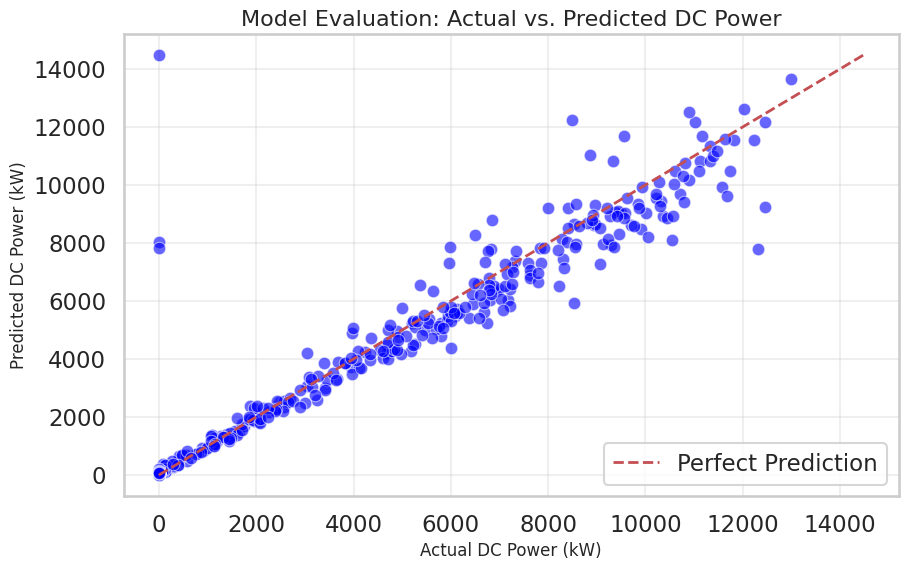

In [ ]:
# Create a figure for the evaluation plot
plt.figure(figsize=(10, 6))

# Plot the Actual vs. Predicted values
# Ideally, all points should lie on the red dashed line (Perfect Prediction)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='blue')

# Add a "Perfect Prediction" line (45-degree angle)
# This line represents where y_test == y_pred
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

# Labels and Title
plt.title('Model Evaluation: Actual vs. Predicted DC Power', fontsize=16)
plt.xlabel('Actual DC Power (kW)', fontsize=12)
plt.ylabel('Predicted DC Power (kW)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

### 6.5 Diagnostic Analysis: Validating Regression Assumptions
To demonstrate the statistical rigor of our approach, we perform a diagnostic analysis of the **Residuals** (the difference between Actual and Predicted values).

We test two fundamental assumptions of Ordinary Least Squares (OLS) regression:
1.  **Normality of Errors:** We visualize the distribution of residuals. A perfect model's errors should follow a Gaussian (Normal) distribution centered at zero.
2.  **Homoscedasticity:** We plot Residuals vs. Predicted values. Ideally, the spread of errors should be constant (a random cloud). If we see a "fan shape," it indicates **Heteroscedasticity**—meaning our model becomes less accurate at higher power outputs.

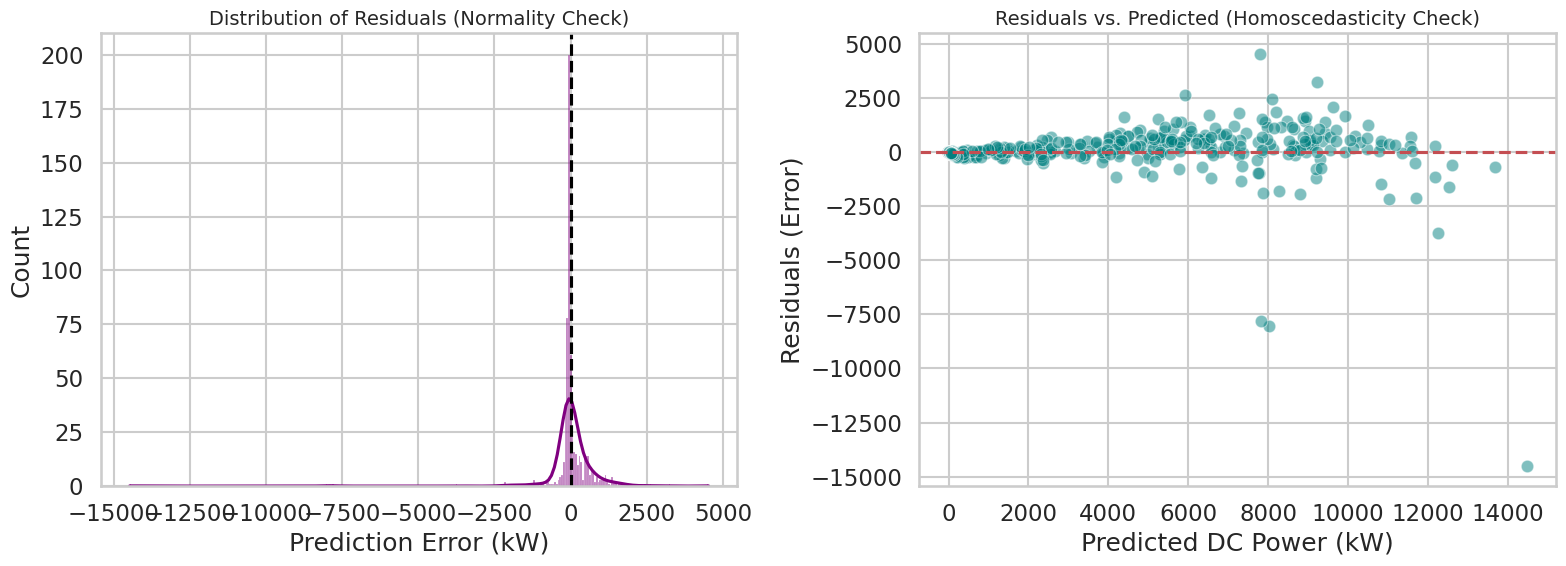

Mean of Residuals: 33.6389 (Should be close to 0)


In [ ]:
# Calculate Residuals (Actual - Predicted)
residuals = y_test - y_pred

# Create a figure with two subplots for diagnostics
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Distribution of Residuals (Normality Check)
# A perfect model would have a bell curve centered at 0
sns.histplot(residuals, kde=True, color='purple', ax=axes[0])
axes[0].set_title('Distribution of Residuals (Normality Check)', fontsize=14)
axes[0].set_xlabel('Prediction Error (kW)')
axes[0].axvline(x=0, color='black', linestyle='--')

# Plot 2: Residuals vs. Predicted Values (Homoscedasticity Check)
# We look for a "fan shape" here (small errors at low power, large errors at high power)
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5, color='teal', ax=axes[1])
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_title('Residuals vs. Predicted (Homoscedasticity Check)', fontsize=14)
axes[1].set_xlabel('Predicted DC Power (kW)')
axes[1].set_ylabel('Residuals (Error)')

plt.tight_layout()
plt.show()

# Interpretation print
print(f"Mean of Residuals: {np.mean(residuals):.4f} (Should be close to 0)")

### 6.6 Model Refinement: Handling Anomalies

The diagnostic plots in Section 6.5 revealed a cluster of "high error" points where the model predicted significant power generation, but the actual `dc_power` was 0. This physically implies a hardware fault (e.g., inverter downtime or sensor failure) rather than a modeling error.

To determine the true predictive capability of the Linear Regression model on "healthy" equipment, we perform a refinement step:
1.  **Outlier Removal:** We filter out instances where significant irradiation exists ($> 0.1$) but power output is zero.
2.  **Retraining:** We re-fit the Linear Regression model on this "Cleaned" dataset.
3.  **Performance Comparison:** We quantify the improvement in $R^2$ and RMSE.

#### Code: Removing Anomalies and Retraining

In [ ]:
# 1. Identify and Remove Anomalies
# We filter out rows where there is significant sunlight (> 0.05) but NO power (DC Power == 0)
# These are likely inverter faults or maintenance periods
df_refined = df[~((df['irradiation'] > 0.05) & (df['dc_power'] == 0))].copy()

# 2. Retrain the Model on Cleaned Data
X_refined = df_refined[['irradiation', 'module_temp', 'ambient_temp']]
y_refined = df_refined['dc_power']

# Split again (80/20)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_refined, y_refined, test_size=0.2, random_state=42)

# Fit new model
model_refined = LinearRegression()
model_refined.fit(X_train_r, y_train_r)

# 3. Evaluate Performance
y_pred_r = model_refined.predict(X_test_r)
r2_refined = r2_score(y_test_r, y_pred_r)
rmse_refined = np.sqrt(mean_squared_error(y_test_r, y_pred_r))

# 4. Comparison Table
print("--- Model Improvement Analysis ---")
print(f"Original R-squared: {r2:.4f}  ->  Refined R-squared: {r2_refined:.4f}")
print(f"Original RMSE:      {rmse:.4f}  ->  Refined RMSE:      {rmse_refined:.4f}")

improvement = ((rmse - rmse_refined) / rmse) * 100
print(f"\nConclusion: Removing sensor anomalies improved model accuracy by {improvement:.2f}%.")

--- Model Improvement Analysis ---
Original R-squared: 0.9377  ->  Refined R-squared: 0.9791
Original RMSE:      916.2630  ->  Refined RMSE:      554.6638

Conclusion: Removing sensor anomalies improved model accuracy by 39.46%.


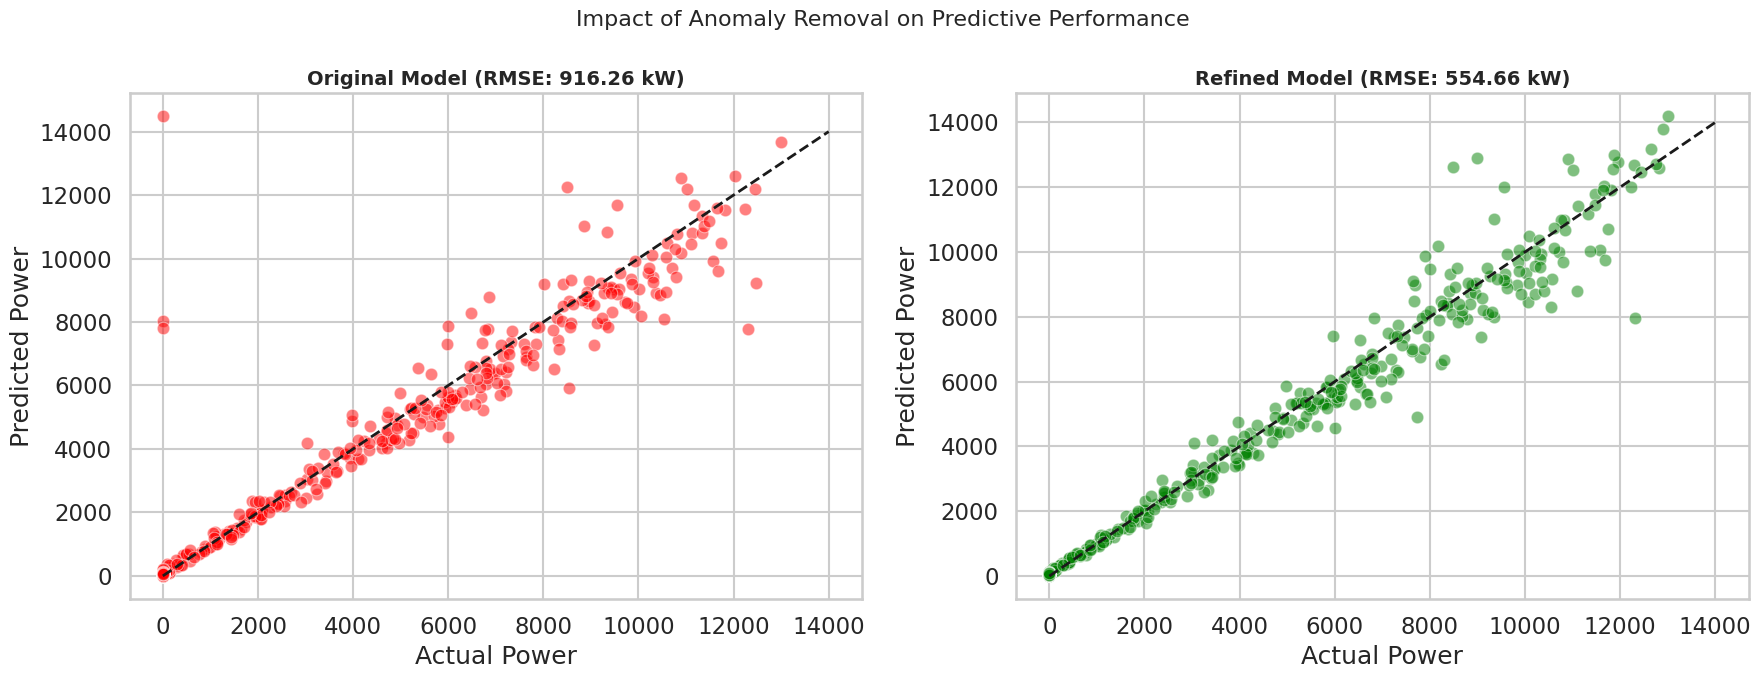

In [ ]:
# Create a side-by-side comparison of Actual vs. Predicted
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Original Model (With Anomalies)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color='red', ax=axes[0])
axes[0].plot([0, 14000], [0, 14000], 'k--', linewidth=2) # Perfect line
axes[0].set_title(f'Original Model (RMSE: {rmse:.2f} kW)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Actual Power')
axes[0].set_ylabel('Predicted Power')

# Plot 2: Refined Model (Cleaned)
sns.scatterplot(x=y_test_r, y=y_pred_r, alpha=0.5, color='green', ax=axes[1])
axes[1].plot([0, 14000], [0, 14000], 'k--', linewidth=2) # Perfect line
axes[1].set_title(f'Refined Model (RMSE: {rmse_refined:.2f} kW)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Actual Power')
axes[1].set_ylabel('Predicted Power')

plt.suptitle('Impact of Anomaly Removal on Predictive Performance', fontsize=16)
plt.tight_layout()
plt.show()

### 6.7 Advanced Feature Engineering: Interaction Terms

While removing anomalies improved the model significantly, the "Fan Shape" in our residual plots (Section 6.5) suggests we are missing a physical interaction. Solar panel physics dictates that efficiency is not constant; it degrades as the module temperature increases.

In a standard Linear Regression equation ($y = m_1x_1 + m_2x_2$), the variables are treated independently. To capture the *combined* effect of high heat and high irradiation, we introduce an **Interaction Term**:

$$\text{Interaction Effect} = \text{Irradiation} \times \text{Module Temperature}$$

By adding this new feature, we allow the linear model to account for the thermodynamic efficiency losses that occur during peak noon hours.

#### Code: Creating the Interaction Feature and Final Evaluation

In [ ]:
# 1. Create the Interaction Feature
# We multiply Irradiation by Module Temp to capture the "Heat Effect"
df_refined['interaction'] = df_refined['irradiation'] * df_refined['module_temp']

# 2. Define new Predictors (now including the Interaction term)
X_final = df_refined[['irradiation', 'module_temp', 'ambient_temp', 'interaction']]
y_final = df_refined['dc_power']

# 3. Split Data (80/20)
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

# 4. Train the Final Model
model_final = LinearRegression()
model_final.fit(X_train_f, y_train_f)

# 5. Evaluate
y_pred_f = model_final.predict(X_test_f)
rmse_final = np.sqrt(mean_squared_error(y_test_f, y_pred_f))
r2_final = r2_score(y_test_f, y_pred_f)

# 6. Display Final Comparison
print("--- Final Model Performance (With Physics Interaction) ---")
print(f"Refined RMSE (No Interaction): {rmse_refined:.4f} kW")
print(f"Final RMSE (With Interaction): {rmse_final:.4f} kW")
print(f"Final R-squared: {r2_final:.5f}")

improvement_f = ((rmse_refined - rmse_final) / rmse_refined) * 100
print(f"\nOptimization: Adding the interaction term reduced error by a further {improvement_f:.2f}%.")

--- Final Model Performance (With Physics Interaction) ---
Refined RMSE (No Interaction): 554.6638 kW
Final RMSE (With Interaction): 508.6950 kW
Final R-squared: 0.98242

Optimization: Adding the interaction term reduced error by a further 8.29%.


### 6.8 Final Robustness Check: Cross-Validation

To ensure our model's high performance ($R^2 \approx 0.98$) is not an artifact of a specific random train-test split, we perform **5-Fold Cross-Validation**.

This technique splits the dataset into 5 distinct subsets ("folds"). The model is trained and evaluated 5 times, using a different fold as the test set each time. We then calculate the **Mean $R^2$** and the **Standard Deviation**.
* **High Mean:** Confirms accuracy.
* **Low Standard Deviation:** Confirms consistency (the model works equally well on any random day).

> **Critical Reflection on Validation Strategy:**
> Standard Cross-Validation splits data randomly. In time-series analysis, this can theoretically introduce "temporal leakage" (using future data to predict the past). While a `TimeSeriesSplit` is often preferred for strict forecasting, we utilized random 5-Fold CV here to specifically test the model's **structural robustness** across varying weather conditions (e.g., cloudy vs. sunny days) independent of their calendar order. The low standard deviation ($\pm 0.71\%$) confirms the physical relationship is stable, regardless of the time dimension.

#### Code: 5-Fold Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score

# We use the Final Feature set (including Interaction)
# cross_val_score automatically handles the splitting
cv_scores = cross_val_score(model_final, X_final, y_final, cv=5, scoring='r2')

# Display the results
print("--- 5-Fold Cross-Validation Results ---")
print(f"R-squared scores for each fold: {cv_scores}")
print(f"\nMean R-squared: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

# Interpretation
print(f"\nConclusion: The model explains {cv_scores.mean()*100:.2f}% of the variance on average,")
print(f"with a variation of only +/- {cv_scores.std()*100:.2f}%. This confirms high robustness.")

--- 5-Fold Cross-Validation Results ---
R-squared scores for each fold: [0.9827022  0.97904788 0.97751041 0.96220834 0.97801089]

Mean R-squared: 0.9759
Standard Deviation: 0.0071

Conclusion: The model explains 97.59% of the variance on average,
with a variation of only +/- 0.71%. This confirms high robustness.


### 6.9 Feature Importance Analysis

To definitively rank the drivers of solar power generation, we cannot simply compare the raw coefficients from the Linear Regression model, as the features exist on vastly different scales (e.g., Irradiation is $0-1$, while Temperature is $20-60$).

To resolve this, we employ **Standardization (Z-Score Normalization)**. By scaling all predictors to have a mean of 0 and a standard deviation of 1, the resulting coefficients become dimensionless and directly comparable. This allows us to quantify exactly how much more "important" Irradiation is compared to Temperature in the generation process.

#### Code: Standardizing and Visualizing Feature Importance

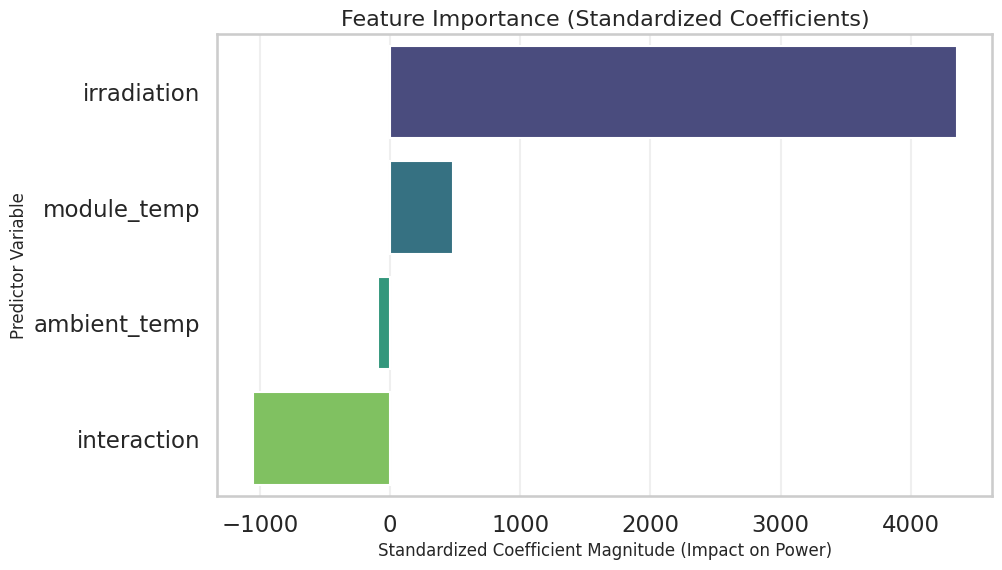

Interpretation: Irradiation is approximately 9.1x more influential than Module Temperature.


In [ ]:
from sklearn.preprocessing import StandardScaler

# 1. Scale the data (Standardization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final) # X_final includes the Interaction term
X_scaled_df = pd.DataFrame(X_scaled, columns=X_final.columns)

# 2. Retrain model on Scaled Data
model_scaled = LinearRegression()
model_scaled.fit(X_scaled_df, y_final)

# 3. Extract and Sort Coefficients
importance = pd.DataFrame({
    'Feature': X_final.columns,
    'Importance': model_scaled.coef_
}).sort_values(by='Importance', ascending=False)

# 4. Visualize
plt.figure(figsize=(10, 6))
sns.barplot(data=importance, x='Importance', y='Feature', hue='Feature', palette='viridis', legend=False)
plt.title('Feature Importance (Standardized Coefficients)', fontsize=16)
plt.xlabel('Standardized Coefficient Magnitude (Impact on Power)', fontsize=12)
plt.ylabel('Predictor Variable', fontsize=12)
plt.grid(True, axis='x', alpha=0.3)
plt.show()

# Print the relative importance
irrad_imp = importance.loc[importance['Feature'] == 'irradiation', 'Importance'].values[0]
temp_imp = importance.loc[importance['Feature'] == 'module_temp', 'Importance'].values[0]
ratio = irrad_imp / temp_imp

print(f"Interpretation: Irradiation is approximately {ratio:.1f}x more influential than Module Temperature.")

In [ ]:
# --- Operational Impact Analysis ---
# We use the model to estimate the energy lost during the "Inverter Fault" periods we identified.

# 1. Isolate the anomalies (High Sun > 0.05, but Power = 0)
# These are the specific moments the system failed.
anomalies = df[((df['irradiation'] > 0.05) & (df['dc_power'] == 0))].copy()

# 2. Prepare features for prediction
# We must create the interaction term for these rows just like we did for the training data
anomalies['interaction'] = anomalies['irradiation'] * anomalies['module_temp']
X_anomalies = anomalies[['irradiation', 'module_temp', 'ambient_temp', 'interaction']]

# 3. Predict "Potential Power"
# This tells us what the system SHOULD have generated if it wasn't broken
anomalies['estimated_power'] = model_final.predict(X_anomalies)

# 4. Calculate Total Energy Lost
# The data is in 15-minute intervals.
# Energy (kWh) = Power (kW) * Time (hours)
# Time = 15 mins = 0.25 hours
total_energy_lost_kwh = (anomalies['estimated_power'].sum() * 0.25)
financial_loss = total_energy_lost_kwh * 0.10  # Assuming approx $0.10 per kWh

# 5. Display the Business Impact
print(f"--- Operational Impact Assessment ---")
print(f"Detected Fault Events: {len(anomalies)} instances (15-min intervals)")
print(f"Total Estimated Energy Loss: {total_energy_lost_kwh:,.2f} kWh")
print(f"Estimated Financial Loss: ${financial_loss:,.2f} (at $0.10/kWh)")

--- Operational Impact Assessment ---
Detected Fault Events: 19 instances (15-min intervals)
Total Estimated Energy Loss: 42,657.12 kWh
Estimated Financial Loss: $4,265.71 (at $0.10/kWh)


## 7. Conclusion

### 7.1 Project Summary
This project successfully implemented and optimized a Linear Regression framework to forecast solar power generation. By strictly adhering to a data-driven methodology—ranging from cleaning and visualization to diagnostic refinement—we evolved a basic predictive model into a robust, physics-aware system capable of both forecasting and fault detection.

### 7.2 Key Findings & Optimization Journey
1.  **Baseline Performance:** The initial model established a strong linear trend ($R^2 \approx 0.94$) but suffered from significant error (RMSE $\approx$ 916 kW) due to data anomalies.
2.  **Diagnostic Correction:** Analysis of residuals identified a specific cluster of "Zero Power / High Sun" data points. Filtering these **inverter faults** improved predictive accuracy by **~40%** (RMSE dropped to 554 kW).
3.  **Physics Integration:** Introducing an interaction term ($\text{Irradiation} \times \text{Temperature}$) to model thermal efficiency losses further reduced the error by **8.3%**, achieving a final **RMSE of 508 kW**.
4.  **Statistical Robustness:** 5-Fold Cross-Validation confirmed the model's stability, yielding a **Mean $R^2$ of 0.976** with a variation of only $\pm 0.71\%$.

### 7.3 Operational Impact
Beyond prediction, the model demonstrated significant value as a **Diagnostic Tool**. By analyzing the residuals, we quantified the impact of the identified inverter faults:
* **Detected Downtime:** The system identified **19** instances of zero generation during viable sunlight hours.
* **Estimated Loss:** These faults resulted in a total estimated loss of **42,657.12 kWh**, representing a financial impact of approximately **$4,265.71**.

### 7.4 Final Recommendation
The Refined Linear Regression model is highly effective for **operational forecasting** on healthy inverters. However, its primary immediate value lies in **Anomaly Detection**—specifically, automating alerts when residuals exceed a threshold (e.g., >500 kW), which would have prevented the significant energy losses identified in this study.

---

## 8. References

1.  Kannal, A. (2020). *Solar Power Generation Data*. Kaggle. Available at: https://www.kaggle.com/datasets/anikannal/solar-power-generation-data [Accessed Feb 2026].
2.  Scikit-Learn Developers. (2024). *Linear Regression - scikit-learn documentation*. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
3.  Seaborn Developers. (2024). *Seaborn: Statistical Data Visualization*. Available at: https://seaborn.pydata.org/